In [0]:
#파이토치 인스톨
!pip install torch torchvision
!pip install -U finance-datareader
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import time

Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.9.6)


In [0]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#실험결과 비교를 위해 시드 고정
seed = 444
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
class stockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=(x_frames+y_frames)*2+10)
        self.end = datetime.date.today()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(x_frames+y_frames)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        if self.x_frames > 1:
            data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        else:
            data = data.apply(lambda x: (x+1) / (10000))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
# 모델 정의
    
class MLPModel(nn.Module):
    # input = 입력값 개수, output = 출력값 개수
    def __init__(self,_input,_output,_hidden_layers): 
        super(MLPModel, self).__init__()
        self.inputv = _input
        self.outputv = _output
        nodes = [_input] + _hidden_layers + [_output]
        self.depth = len(nodes)
        linears = [nn.Linear(nodes[i], nodes[i+1]) for i in range(self.depth-1)]
        self.linears = nn.ModuleList(linears)
        self.relu = nn.ReLU()
        
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        for linear in self.linears[:-1]: 
          x = linear(x)
          x = self.relu(x)
        x = self.linears[-1](x)

        return x

In [0]:

#trainloader = torch.cat(trainloader).view(len(trainloader), batch_size, -1)
def train(model, trainset, optimizer, loss_fn,device):
    trainloader = DataLoader(trainset, shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.float().to(device)
        y_true = y[:, :, 3].float().to(device)

        model.zero_grad()
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return model, train_loss

In [0]:
def validate(model, valset, loss_fn,device):
    valloader = DataLoader(valset, shuffle=False, drop_last=True)
    model.eval()

    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.float().to(device)
            y_true = y[:, :, 3].float().to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()

    val_loss = val_loss / len(valloader)
    return val_loss


In [0]:
def test(model, testStock, loss_fn, device):
    testloader = DataLoader(testStock, shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    test_result = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.float().to(device)
            y_true = y[:, :, 3].float().to(device)
            
            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            test_result.append([y_pred,y_true])
            test_acc += loss.item()

    test_acc = test_acc / len(testloader)
    return test_acc, test_result

In [0]:
trainset = StockDataset('001040',1,1,(2018,5,1),(2020,5,20))
valset = StockDataset('005930',1,1,(2018,5,1),(2020,5,20))
testset = StockDataset('005930',1,1,(2015,1,1),(2015,12,30))

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64


In [0]:
batch_size = 1
input_dim = 6
hidden_dim = 50
output_dim = 1
layers = [200,100,50,25,15,10,5]
epoch = 10

model = MLPModel(input_dim,output_dim,layers)
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

MLPModel(
  (linears): ModuleList(
    (0): Linear(in_features=6, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=25, bias=True)
    (4): Linear(in_features=25, out_features=15, bias=True)
    (5): Linear(in_features=15, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Linear(in_features=5, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [0]:
list_epoch = []
list_train_loss = []
list_val_loss = []

In [0]:
for e in range(epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss = train(model, trainset ,optimizer, loss_fn,device)
        val_loss = validate(model, valset, loss_fn,device)
        te = time.time()

        list_epoch.append(e)
        list_train_loss.append(train_loss)
        list_val_loss.append(val_loss)
        print('Epoch {}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(e, train_loss, val_loss, te-ts))

test_acc, test_result = test(model, testset, loss_fn,device)
print(test_acc)

Epoch 0, Loss(train/val) 2.17272/5490.43444. Took 10.20 sec
Epoch 1, Loss(train/val) 0.95096/2962.50129. Took 10.22 sec
Epoch 2, Loss(train/val) 0.48494/978.94341. Took 10.52 sec
Epoch 3, Loss(train/val) 0.46614/2375.66550. Took 10.38 sec
Epoch 4, Loss(train/val) 0.58535/1882.85402. Took 10.05 sec
Epoch 5, Loss(train/val) 0.29639/1294.23502. Took 10.33 sec
Epoch 6, Loss(train/val) 0.45171/3477.13261. Took 10.21 sec
Epoch 7, Loss(train/val) 0.40054/765.25410. Took 10.26 sec
Epoch 8, Loss(train/val) 0.50433/1953.32689. Took 10.27 sec
Epoch 9, Loss(train/val) 0.47943/810.61320. Took 10.53 sec
0.42398855512441413


In [0]:
class pltClass():

    def __init__(self,_list_epoch, _list_train_loss, _list_val_loss):
        self.list_epoch = _list_epoch
        self.list_train_loss= _list_train_loss
        self.list_val_loss = _list_val_loss


    def printFigure(self):
        fig = plt.figure(figsize=(24,5))


        # ====== train plot ====== #
        ax3 = fig.add_subplot(1, 2, 1)
        ax3.plot(self.list_epoch, self.list_train_loss, marker='x', label='train')

        ax3.set_xlabel('epoch')
        ax3.set_ylabel('loss')
        ax3.grid()
        ax3.legend()
        ax3.set_title('epoch vs loss')

        # ====== valid plot ====== #
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(self.list_epoch, self.list_val_loss, '--', label='val')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
        #ax1.set_ylim(0, 5)
        ax2.grid()
        ax2.legend()
        ax2.set_title('epoch vs loss')


        plt.show()



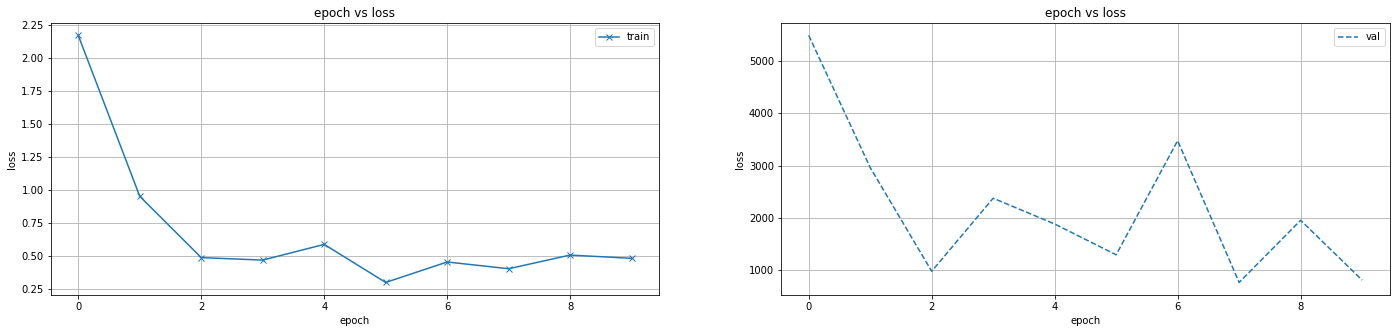

In [0]:

pltc = pltClass(list_epoch, list_train_loss,list_val_loss)
pltc.printFigure()

In [0]:
'''model.to('cpu')
model.eval()

prediction = model(torch.Tensor(test_X))
pred = []
real = test_y
for i in prediction[:].T:
    for j in i:
        pred.append(j.item())

print(real)
print(pred)
'''

"model.to('cpu')\nmodel.eval()\n\nprediction = model(torch.Tensor(test_X))\npred = []\nreal = test_y\nfor i in prediction[:].T:\n    for j in i:\n        pred.append(j.item())\n\nprint(real)\nprint(pred)\n"

In [0]:
'''from google.colab import drive
drive.mount('/content/gdrive')'''

"from google.colab import drive\ndrive.mount('/content/gdrive')"

In [0]:
'''modelPath = '/content/gdrive/My Drive/MLP_batch_1_model.pt'
torch.save(model.state_dict(), modelPath)'''

"modelPath = '/content/gdrive/My Drive/MLP_batch_1_model.pt'\ntorch.save(model.state_dict(), modelPath)"

[tensor([[2.6661]], device='cuda:0'), tensor([[2.5901]], device='cuda:0'), tensor([[2.6141]], device='cuda:0'), tensor([[2.6281]], device='cuda:0'), tensor([[2.6281]], device='cuda:0'), tensor([[2.6321]], device='cuda:0'), tensor([[2.6781]], device='cuda:0'), tensor([[2.6901]], device='cuda:0'), tensor([[2.6681]], device='cuda:0'), tensor([[2.6321]], device='cuda:0'), tensor([[2.6861]], device='cuda:0'), tensor([[2.7441]], device='cuda:0'), tensor([[2.7901]], device='cuda:0'), tensor([[2.7561]], device='cuda:0'), tensor([[2.7721]], device='cuda:0'), tensor([[2.7781]], device='cuda:0'), tensor([[2.8001]], device='cuda:0'), tensor([[2.7561]], device='cuda:0'), tensor([[2.7201]], device='cuda:0'), tensor([[2.7301]], device='cuda:0'), tensor([[2.7361]], device='cuda:0'), tensor([[2.7321]], device='cuda:0'), tensor([[2.7181]], device='cuda:0'), tensor([[2.7161]], device='cuda:0'), tensor([[2.7441]], device='cuda:0'), tensor([[2.7901]], device='cuda:0'), tensor([[2.7561]], device='cuda:0'), 

Text(0.5, 1.0, 'pred vs real')

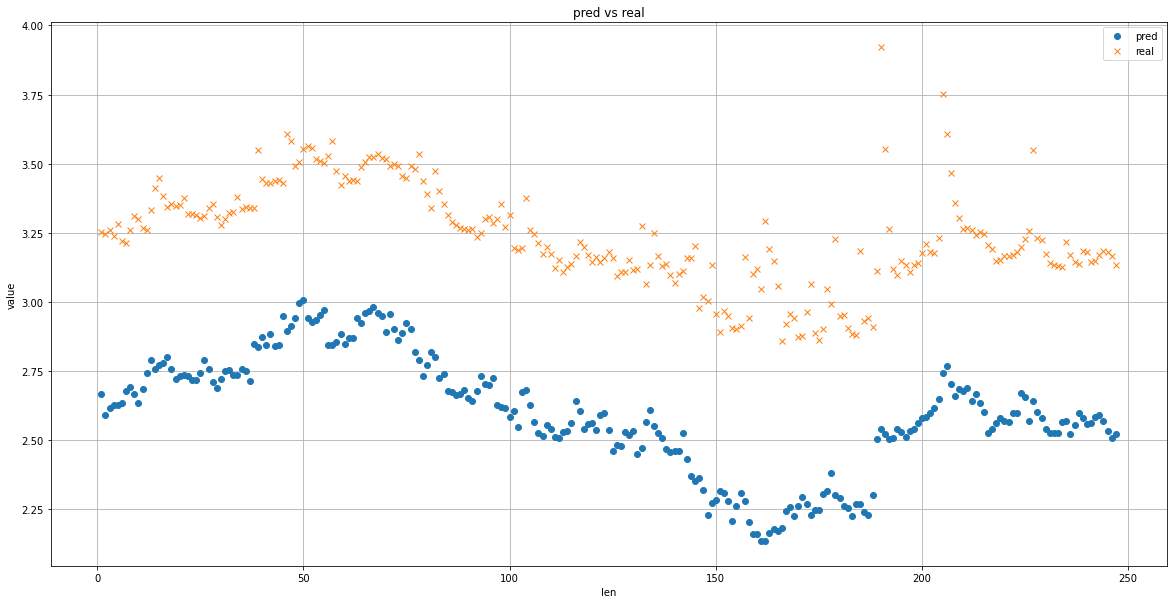

In [0]:
fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(test_result)+1)]

pred = []
real = []
for i in test_result:
    pred.append(i[1])
    real.append(i[0])

# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, pred, 'o', label='pred')
ax.plot(xl, real, 'x', label='real')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')